## this notebook represents the cleaning of "PDL total daily load". THe same approach is applied to clean "max PDL daily load" as they share the same characteristics (especially the weekly seasonality) 

# Winsorization for data cleaning

"Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers". (Wikipedia https://en.wikipedia.org/wiki/Winsorizing)

"The distribution of many statistics can be heavily influenced by outliers. A typical strategy is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. **Winsorized estimators are usually more robust to outliers than their more standard forms**"(wikipedia)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

In [ ]:
#extract pdl_total_daily_load from df_human_logic
df = pd.read_csv('/content/df_human_logic.csv')[['time','pdl_total_daily_load']].dropna()
df.time=pd.to_datetime(df.time,dayfirst=True)

In [ ]:
df.head()

,time,pdl_total_daily_load
0,2015-01-01,16580
1,2015-01-02,22006
2,2015-01-03,18629
3,2015-01-04,18060
4,2015-01-05,20122


In [ ]:
df.tail()

,time,pdl_total_daily_load
2003,2020-06-26,13461
2004,2020-06-27,12932
2005,2020-06-28,11265
2006,2020-06-29,13974
2007,2020-06-30,13626


In [ ]:
#a copy from df
df_copy=df

In [ ]:
#explore data statistics
df.pdl_total_daily_load = pd.to_numeric(df.pdl_total_daily_load)

df.describe().T


,count,mean,std,min,25%,50%,75%,max
pdl_total_daily_load,2008.0,13624.153884,5161.478508,0.0,10007.0,12855.0,17312.75,27936.0


In [ ]:
#we are going to clean data season by season because every season has its own patterns
df['quarter'] = df['time'].dt.quarter


#we add "weekday" column because there is weekly seasonality in the data
df['weekday'] = pd.Categorical(df.time.dt.strftime('%A'), categories=['Monday','Tuesday',
                'Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2007
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  2008 non-null   datetime64[ns]
 1   pdl_total_daily_load  2008 non-null   int64         
 2   weekday               2008 non-null   category      
 3   quarter               2008 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2)
memory usage: 65.1 KB


In [ ]:
df.head()

,time,pdl_total_daily_load,weekday,quarter
0,2015-01-01,16580,Thursday,1
1,2015-01-02,22006,Friday,1
2,2015-01-03,18629,Saturday,1
3,2015-01-04,18060,Sunday,1
4,2015-01-05,20122,Monday,1


In [ ]:
df.tail()

,time,pdl_total_daily_load,weekday,quarter
2003,2020-06-26,13461,Friday,2
2004,2020-06-27,12932,Saturday,2
2005,2020-06-28,11265,Sunday,2
2006,2020-06-29,13974,Monday,2
2007,2020-06-30,13626,Tuesday,2


# Quarter1: winter

In [ ]:
consom1=df[df['quarter']==1]
c1=consom1 #copy from winter data

In [ ]:
consom1.head()

,time,pdl_total_daily_load,weekday,quarter
0,2015-01-01,16580,Thursday,1
1,2015-01-02,22006,Friday,1
2,2015-01-03,18629,Saturday,1
3,2015-01-04,18060,Sunday,1
4,2015-01-05,20122,Monday,1


the weekly seasonality is demonstrated in https://colab.research.google.com/drive/1uGtjWDCRKIXtR_X2gyGtj1OoYpUEfAb8

In [ ]:
#we add a columns that represents the average total daily load of every weekday
consom1_final=consom1.join(consom1.groupby(['weekday'])['pdl_total_daily_load'].mean(),
                           on=['weekday'],rsuffix='_avg')

In [ ]:
consom1_final[:8]

,time,pdl_total_daily_load,weekday,quarter,pdl_total_daily_load_avg
0,2015-01-01,16580,Thursday,1,18858.679487
1,2015-01-02,22006,Friday,1,19367.987179
2,2015-01-03,18629,Saturday,1,18553.597403
3,2015-01-04,18060,Sunday,1,17889.493506
4,2015-01-05,20122,Monday,1,18471.298701
5,2015-01-06,18182,Tuesday,1,18326.307692
6,2015-01-07,20928,Wednesday,1,18700.545455
7,2015-01-08,20809,Thursday,1,18858.679487


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


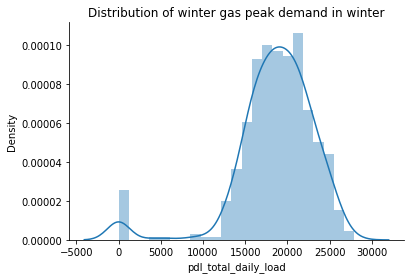

In [ ]:
import seaborn as sns

#plot data distribution
sns.distplot(consom1['pdl_total_daily_load'])
plt.title("Distribution of winter gas peak demand in winter")
sns.despine()

visible outliers around 5000 and 0, we are going to replace them by their corresponding daily total PDL load average (because of weekly seasonality). i.e for example if an outlier's day is Monday then we replace its PDL value by the PDL average corresponding to Monday.

In [ ]:
###modified winsorization
##by error and trial process we choose the percentiles 0.035 and 0.995
#i.e percentiles below 0.035 are replaced by their cooresponding average values and percentiles above 
#0.995 are replaced by their corresponding average values
print(c1['pdl_total_daily_load'].quantile(0.035))
print(c1['pdl_total_daily_load'].quantile(0.995))

8464.825000000006
26518.514999999985


**Replace outliers**

In [ ]:
consom1_final.loc[(consom1_final['pdl_total_daily_load']  < 
                   consom1_final['pdl_total_daily_load'].quantile(0.035))|
                  (consom1_final['pdl_total_daily_load']  > 
                   consom1_final['pdl_total_daily_load'].quantile(0.995)),
                  'pdl_total_daily_load' ] = consom1_final.pdl_total_daily_load_avg

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


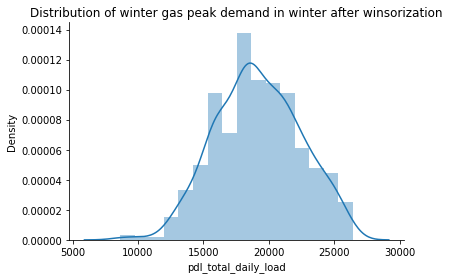

In [ ]:
import seaborn as sns

#plot of data distribution after cleaning
sns.distplot(consom1_final['pdl_total_daily_load'])
plt.title("Distribution of winter gas peak demand in winter after winsorization")
sns.despine()

In [ ]:
consom1=consom1_final[['time','pdl_total_daily_load']]
consom1.head()

,time,pdl_total_daily_load
0,2015-01-01,16580.0
1,2015-01-02,22006.0
2,2015-01-03,18629.0
3,2015-01-04,18060.0
4,2015-01-05,20122.0


## the same approach is applied for the remaining seasons

# Quarter2: spring

In [ ]:
consom2=df[df['quarter']==2]
c2=consom2 #copy

In [ ]:
consom2.head()

,time,pdl_total_daily_load,weekday,quarter
90,2015-04-01,11434,Wednesday,2
91,2015-04-02,16752,Thursday,2
92,2015-04-03,16122,Friday,2
93,2015-04-04,13429,Saturday,2
94,2015-04-05,9767,Sunday,2


In [ ]:
consom2_final=consom2.join(consom2.groupby(['weekday'])['pdl_total_daily_load'].mean(),
                           on=['weekday'],rsuffix='_avg')

In [ ]:
consom2_final[:8]

,time,pdl_total_daily_load,weekday,quarter,pdl_total_daily_load_avg
90,2015-04-01,11434,Wednesday,2,12997.974359
91,2015-04-02,16752,Thursday,2,12925.474359
92,2015-04-03,16122,Friday,2,12775.576923
93,2015-04-04,13429,Saturday,2,12026.076923
94,2015-04-05,9767,Sunday,2,10964.461538
95,2015-04-06,12373,Monday,2,12702.435897
96,2015-04-07,14322,Tuesday,2,12804.346154
97,2015-04-08,16005,Wednesday,2,12997.974359


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


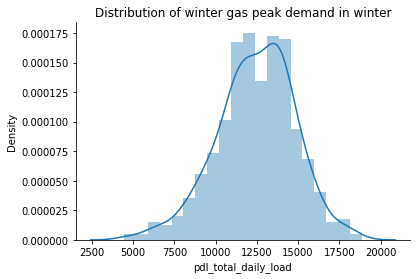

In [ ]:
import seaborn as sns

sns.distplot(consom2['pdl_total_daily_load'])
plt.title("Distribution of winter gas peak demand in spring")
sns.despine()

no visible outliers according to the spring data distribution, so no need to apply the "modified winsorization"

In [ ]:
consom2=consom2_final[['time','pdl_total_daily_load']]
consom2.head()

,time,pdl_total_daily_load
90,2015-04-01,11434
91,2015-04-02,16752
92,2015-04-03,16122
93,2015-04-04,13429
94,2015-04-05,9767


# Quarter3: summer

In [ ]:
consom3=df[df['quarter']==3]
c3=consom3 #copy

In [ ]:
consom3.head()

,time,pdl_total_daily_load,weekday,quarter
181,2015-07-01,7586,Wednesday,3
182,2015-07-02,6880,Thursday,3
183,2015-07-03,6175,Friday,3
184,2015-07-04,6029,Saturday,3
185,2015-07-05,4809,Sunday,3


In [ ]:
consom3_final=consom3.join(consom3.groupby(['weekday'])['pdl_total_daily_load'].mean(),
                           on=['weekday'],rsuffix='_avg')

In [ ]:
consom3_final[:8]

,time,pdl_total_daily_load,weekday,quarter,pdl_total_daily_load_avg
181,2015-07-01,7586,Wednesday,3,9285.242424
182,2015-07-02,6880,Thursday,3,9159.415385
183,2015-07-03,6175,Friday,3,9059.651515
184,2015-07-04,6029,Saturday,3,8185.181818
185,2015-07-05,4809,Sunday,3,6872.515152
186,2015-07-06,6784,Monday,3,9088.212121
187,2015-07-07,7249,Tuesday,3,9151.938462
188,2015-07-08,7089,Wednesday,3,9285.242424


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


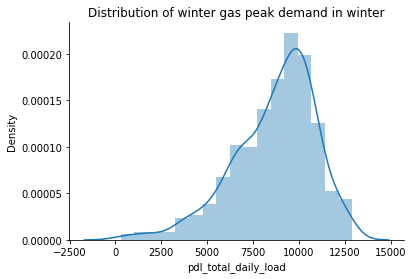

In [ ]:
import seaborn as sns

sns.distplot(consom3['pdl_total_daily_load'])
plt.title("Distribution of winter gas peak demand in summer")
sns.despine()

visible outliers close to 0

In [ ]:
#choose percentile 0.05 & 0.995 
print(c3['pdl_total_daily_load'].quantile(0.05))
print(c3['pdl_total_daily_load'].quantile(0.995))

4401.75
12635.48


**Replace outliers**

In [ ]:
consom3_final.loc[(consom3_final['pdl_total_daily_load']  < 
                   consom3_final['pdl_total_daily_load'].quantile(0.05))|
                  (consom3_final['pdl_total_daily_load']  > 
                   consom3_final['pdl_total_daily_load'].quantile(0.995)),
                  'pdl_total_daily_load' ] = consom3_final.pdl_total_daily_load_avg

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


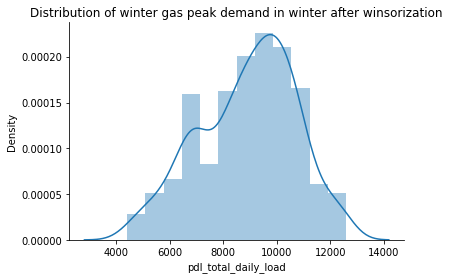

In [ ]:
import seaborn as sns

sns.distplot(consom3_final['pdl_total_daily_load'])
plt.title("Distribution of winter gas peak demand in summer after winsorization")
sns.despine()

In [ ]:
consom3=consom3_final[['time','pdl_total_daily_load']]
consom3.head()

,time,pdl_total_daily_load
181,2015-07-01,7586.0
182,2015-07-02,6880.0
183,2015-07-03,6175.0
184,2015-07-04,6029.0
185,2015-07-05,4809.0


# Quarter4: autumn

In [ ]:
consom4=df[df['quarter']==4]
c4=consom4 #copy

In [ ]:
consom4.head()

,time,pdl_total_daily_load,weekday,quarter
273,2015-10-01,9879,Thursday,4
274,2015-10-02,10048,Friday,4
275,2015-10-03,7861,Saturday,4
276,2015-10-04,7236,Sunday,4
277,2015-10-05,9033,Monday,4


In [ ]:
consom4_final=consom4.join(consom4.groupby(['weekday'])['pdl_total_daily_load'].mean(),
                           on=['weekday'],rsuffix='_avg')

In [ ]:
consom4_final[:8]

,time,pdl_total_daily_load,weekday,quarter,pdl_total_daily_load_avg
273,2015-10-01,9879,Thursday,4,14746.878788
274,2015-10-02,10048,Friday,4,14789.523077
275,2015-10-03,7861,Saturday,4,13814.545455
276,2015-10-04,7236,Sunday,4,12604.363636
277,2015-10-05,9033,Monday,4,14055.515152
278,2015-10-06,8660,Tuesday,4,14076.909091
279,2015-10-07,8735,Wednesday,4,14567.261538
280,2015-10-08,8018,Thursday,4,14746.878788


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


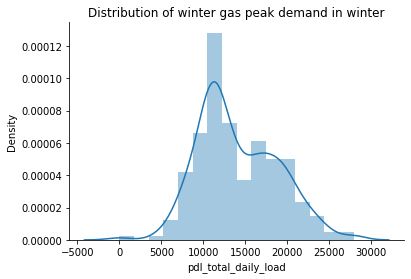

In [ ]:
import seaborn as sns

sns.distplot(consom4['pdl_total_daily_load'])
plt.title("Distribution of winter gas peak demand in autumn")
sns.despine()

visible outliers around zero

In [ ]:
#we choose 0.05 and 0.995
print(c4['pdl_total_daily_load'].quantile(0.005))
print(c4['pdl_total_daily_load'].quantile(0.995))

4430.13
27936.0


**Replace outliers**

In [ ]:
consom4_final.loc[(consom4_final['pdl_total_daily_load']  < 
                   consom4_final['pdl_total_daily_load'].quantile(0.005))|
                  (consom4_final['pdl_total_daily_load']  > 
                   consom4_final['pdl_total_daily_load'].quantile(0.995)),
                  'pdl_total_daily_load' ] = consom4_final.pdl_total_daily_load_avg

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


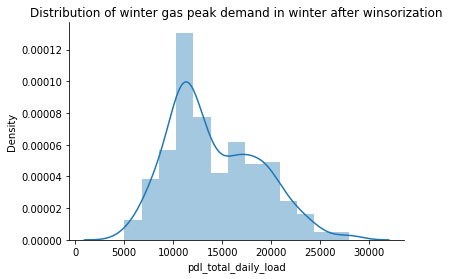

In [ ]:
import seaborn as sns

sns.distplot(consom4_final['pdl_total_daily_load'])
plt.title("Distribution of winter gas peak demand in autumn after winsorization")
sns.despine()

In [ ]:
consom4=consom4_final[['time','pdl_total_daily_load']]
consom4.head()

,time,pdl_total_daily_load
273,2015-10-01,9879.0
274,2015-10-02,10048.0
275,2015-10-03,7861.0
276,2015-10-04,7236.0
277,2015-10-05,9033.0


# concat results of cleaning of the different seasons

In [ ]:
clean_pdl=pd.concat([consom1,consom2,consom3,consom4]).sort_values(by='time')

In [ ]:
clean_pdl[['time','pdl_total_daily_load']]

,time,pdl_total_daily_load
0,2015-01-01,16580.0
1,2015-01-02,22006.0
2,2015-01-03,18629.0
3,2015-01-04,18060.0
4,2015-01-05,20122.0
...,...,...
2003,2020-06-26,13461.0
2004,2020-06-27,12932.0
2005,2020-06-28,11265.0
2006,2020-06-29,13974.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


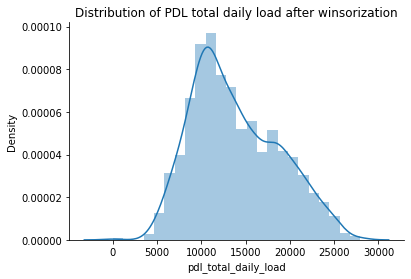

In [ ]:
import seaborn as sns

sns.distplot(clean_pdl['pdl_total_daily_load'])
plt.title("Distribution of PDL total daily load after winsorization")
sns.despine()

In [ ]:
#export the clean dataset
clean_pdl[['time','pdl_total_daily_load']].to_csv('pdl_daily_total_clean.csv')

## this notebook represents the cleaning of "PDL total daily load". THe same approach is applied to clean "max PDL daily load" as they share the weekly seasonality 